<a href="https://colab.research.google.com/github/MohamedBechir361/Data_Science_Projects/blob/main/Electricity_price_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid modeling approach for day-ahead electricty prices forecast in France



## Initialisation

In [254]:
#!pip install holidays

In [255]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import holidays

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline           # Create Pipeline
from sklearn.compose import ColumnTransformer   # Link pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [256]:
warnings.filterwarnings('ignore')  # Suppress all warnings

**Loading Datasets**

In this project, we will be using three open-source datasets. The first one contains electricity prices in France at an hourly frequency, from 2015-01-01 01:00:00 to 2025-11-10 10:00:00. Th data is available at https://ember-energy.org/data/european-wholesale-electricity-price-data/.

The second dataset contains weather data from the "France Energy and Weather Data hourly/daily" available in KAGGLE : https://www.kaggle.com/datasets/ravvvvvvvvvvvv/france-energy-weather-hourly/data.
It contains weather data such as : wind speed and direction, temperatures, global irradiance, cloud coverage... and electricity consumption, all available in several regions in France.

The last dataset contains the GTT prices from 2023 to April 2024 available at : https://www.abcbourse.com/graphes/eod/GTTp.

The GTT prices are considered a good approximation of real natural gaz prices.

In [257]:
path_price = "/content/drive/MyDrive/Projet_forecast/France.csv"
prices = pd.read_csv(path_price)
prices = prices.drop(["Country",	"ISO3 Code",	"Datetime (UTC)"],axis=1)
prices["Datetime (Local)"] = pd.to_datetime(prices["Datetime (Local)"], format = '%Y-%m-%d %H:%M:%S')

"""# Ensure unique index before setting it
prices.drop_duplicates(subset=["Datetime (Local)"], keep="first", inplace=True)"""
prices.set_index("Datetime (Local)", inplace=True)

path_weather = "/content/drive/MyDrive/Projet_forecast/merged_hourly_regional.csv"
weather = pd.read_csv(path_weather)


In order to reduce the number of features to be used, we selected 6 regions from the available data as an approximation of the weather in most of metropolitan France (West, North, The Capital, center, south-est and southwest). Additionnally, some of the available ata are not commonly used for electricity prices forecast, so we selected the most important features only.

In [258]:
selected_regions = [11, 24, 44, 52, 75, 84]
selected_weather_features = [ "conso_elec_mw","temperature_2m","precipitation","cloud_cover","global_tilted_irradiance","wind_speed_100m","wind_direction_100m"]
weather = weather[['datetime_hour', 'insee_region']+ selected_weather_features]
weather = weather[weather['insee_region'].isin(selected_regions)]


In [259]:
# Function to rename columns with region code
def add_region_suffix(df, features, region_col="region"):
    # Get unique region codes
    regions = df[region_col].unique()

    # Create new column names for each feature per region
    new_columns = {}
    for feature in features:
        for region in regions:
            new_name = f"{feature}_{region}"
            # Map old column (feature) to new name if region matches
            new_columns[(feature, region)] = new_name

    # Pivot or transform depending on your structure
    # Example: if you want separate columns per region
    transformed = df.pivot_table(index="datetime_hour", columns=region_col, values=features)

    # Flatten multi-index columns
    transformed.columns = [f"{col}_{region}" for col, region in transformed.columns]

    return transformed.reset_index()

weather_transf = add_region_suffix(weather,selected_weather_features,region_col="insee_region")
weather_transf.head()

,datetime_hour,cloud_cover_11,cloud_cover_24,cloud_cover_44,cloud_cover_52,cloud_cover_75,cloud_cover_84,conso_elec_mw_11,conso_elec_mw_24,conso_elec_mw_44,...,wind_direction_100m_44,wind_direction_100m_52,wind_direction_100m_75,wind_direction_100m_84,wind_speed_100m_11,wind_speed_100m_24,wind_speed_100m_44,wind_speed_100m_52,wind_speed_100m_75,wind_speed_100m_84
0,2013-01-01 00:00:00,100.0,100.0,87.0,100.0,100.0,81.0,0.0,0.0,0.0,...,198.0,213.0,195.0,188.0,41.7,34.0,29.6,48.9,28.7,37.8
1,2013-01-01 01:00:00,100.0,100.0,93.0,100.0,100.0,93.0,17956.0,4795.0,9754.0,...,199.0,217.0,201.0,188.0,41.7,29.5,30.1,46.6,30.8,37.4
2,2013-01-01 02:00:00,100.0,100.0,100.0,100.0,100.0,94.0,16728.0,4955.0,9737.0,...,199.0,218.0,207.0,189.0,40.0,27.9,29.3,44.6,32.2,39.4
3,2013-01-01 03:00:00,100.0,100.0,100.0,100.0,100.0,97.0,15998.0,4677.0,9567.0,...,203.0,219.0,210.0,188.0,38.7,26.9,28.2,39.9,32.4,40.3
4,2013-01-01 04:00:00,100.0,97.0,98.0,100.0,100.0,99.0,15107.0,4223.0,9010.0,...,202.0,220.0,215.0,188.0,38.4,28.8,29.1,34.8,32.1,40.3


In [260]:
weather_transf['datetime_hour'] = pd.to_datetime(weather_transf['datetime_hour'])
# Ensure unique index before setting it
weather_transf.drop_duplicates(subset=["datetime_hour"], keep="first", inplace=True)
weather_transf = weather_transf.set_index("datetime_hour")
weather_train = weather_transf[weather_transf.index.year == 2023]
weather_test = weather_transf[(weather_transf.index.year == 2024) & (weather_transf.index.month == 1) & (weather_transf.index.day <= 15)]


In [261]:
prices2023 = prices[prices.index.year == 2023]['Price (EUR/MWhe)']
y_test = prices[(prices.index.year == 2024) & (prices.index.month == 1) & (prices.index.day <= 15)]['Price (EUR/MWhe)']

In [262]:
weather_transf.tail()

,cloud_cover_11,cloud_cover_24,cloud_cover_44,cloud_cover_52,cloud_cover_75,cloud_cover_84,conso_elec_mw_11,conso_elec_mw_24,conso_elec_mw_44,conso_elec_mw_52,...,wind_direction_100m_44,wind_direction_100m_52,wind_direction_100m_75,wind_direction_100m_84,wind_speed_100m_11,wind_speed_100m_24,wind_speed_100m_44,wind_speed_100m_52,wind_speed_100m_75,wind_speed_100m_84
datetime_hour,,,,,,,,,,,,,,,,,,,,,
2024-04-29 20:00:00,100.0,24.0,100.0,100.0,100.0,99.0,15079.0,3608.0,9365.0,5464.0,...,344.0,177.0,9.0,344.0,14.9,20.5,19.8,18.0,7.3,15.7
2024-04-29 21:00:00,100.0,9.0,100.0,100.0,100.0,58.0,14444.0,3553.0,8704.0,5344.0,...,352.0,168.0,330.0,345.0,15.8,19.1,23.3,18.0,12.9,18.6
2024-04-29 22:00:00,100.0,2.0,100.0,100.0,100.0,87.0,13875.0,3590.0,8973.0,5103.0,...,5.0,159.0,329.0,344.0,24.9,20.6,24.9,19.7,16.8,18.7
2024-04-29 23:00:00,100.0,0.0,100.0,100.0,100.0,77.0,13852.0,3598.0,9675.0,5615.0,...,5.0,163.0,351.0,338.0,21.4,24.1,22.8,23.0,17.9,16.6
2024-04-30 00:00:00,59.0,0.0,100.0,100.0,100.0,52.0,6568.0,1871.0,4408.0,2801.0,...,9.0,181.0,3.0,324.0,20.9,22.3,24.1,20.9,18.0,15.2


### GTT Prices processing

The available data for GTT prices are actually on a daily basis, and several dates are ommitted like weekends. To fix this, we will start by filling missing dates with the nearest available value (Meaning that Fridays and Saturdays will have the same value, and Sundays and Mondays too). The next step will be to linearly interpolate between two available values in order to have hourly data.  

In [263]:
path_GTT = "/content/drive/MyDrive/Projet_forecast/GTT daily index 23_24.xlsx"
GTT = pd.read_excel(path_GTT)

In [264]:
GTT.Date = pd.to_datetime(GTT.Date)
GTT.set_index("Date", inplace=True)
GTT.head()

,Ouverture,Plus Haut,Plus Bas,Volume,Dernier,Variation
Date,,,,,,
2023-01-02,100.90,101.30,99.60,39 715,99.65,0.0000
2023-01-03,96.00,98.45,92.00,197 055,96.00,-0.0366
2023-01-04,96.85,96.90,93.10,174 178,93.30,-0.0281
2023-01-05,94.70,96.25,93.75,98 057,94.80,0.0161
2023-01-06,94.90,98.10,94.80,117 735,97.40,0.0274


In [265]:
idx = pd.date_range('01-01-2023', '28-06-2024', freq ='D')
GTT = GTT.reindex(idx, method = 'nearest')

<Axes: >

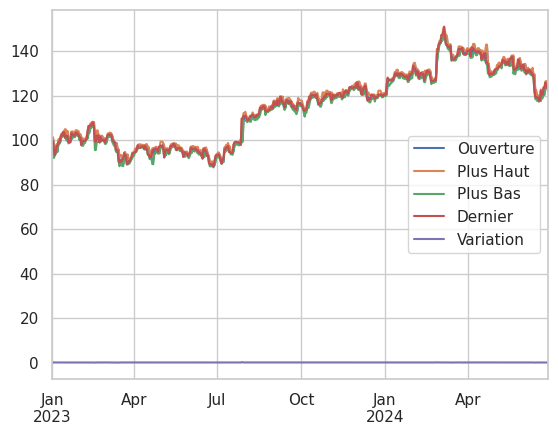

In [266]:
GTT.plot()

In [267]:
GTT = GTT.resample('h').interpolate(method='linear')
GTT.head()

,Ouverture,Plus Haut,Plus Bas,Volume,Dernier,Variation
2023-01-01 00:00:00,100.9,101.3,99.6,39 715,99.65,0.0
2023-01-01 01:00:00,100.9,101.3,99.6,NaN,99.65,0.0
2023-01-01 02:00:00,100.9,101.3,99.6,NaN,99.65,0.0
2023-01-01 03:00:00,100.9,101.3,99.6,NaN,99.65,0.0
2023-01-01 04:00:00,100.9,101.3,99.6,NaN,99.65,0.0


In [268]:
GTT.drop(columns=['Volume'], inplace= True)

In [269]:
GTT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13057 entries, 2023-01-01 00:00:00 to 2024-06-28 00:00:00
Freq: h
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ouverture  13057 non-null  float64
 1   Plus Haut  13057 non-null  float64
 2   Plus Bas   13057 non-null  float64
 3   Dernier    13057 non-null  float64
 4   Variation  13057 non-null  float64
dtypes: float64(5)
memory usage: 612.0 KB


In [270]:
display(GTT.head())

,Ouverture,Plus Haut,Plus Bas,Dernier,Variation
2023-01-01 00:00:00,100.9,101.3,99.6,99.65,0.0
2023-01-01 01:00:00,100.9,101.3,99.6,99.65,0.0
2023-01-01 02:00:00,100.9,101.3,99.6,99.65,0.0
2023-01-01 03:00:00,100.9,101.3,99.6,99.65,0.0
2023-01-01 04:00:00,100.9,101.3,99.6,99.65,0.0


## Seasonal Features

### Fourier Features

If we plot the hourly electricty prices for each day in the training set (2023), we observe a clear bidaily seasonality with two peaks occuring everyday around 8am and 7pm, with +- 1 hour.

Using the Spectrogram, we can also analyse the seasonality of the data and identify the different frequencies that exist.

This leads us to start by creating Fourier Features (cosine and sinus) features, each of one applied at a different frequency. We will start by the yearly, weekly and daily seasonality.

In [271]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


<Axes: title={'center': 'Seasonal Plot (day/hour)'}, xlabel='hour', ylabel='Price (EUR/MWhe)'>

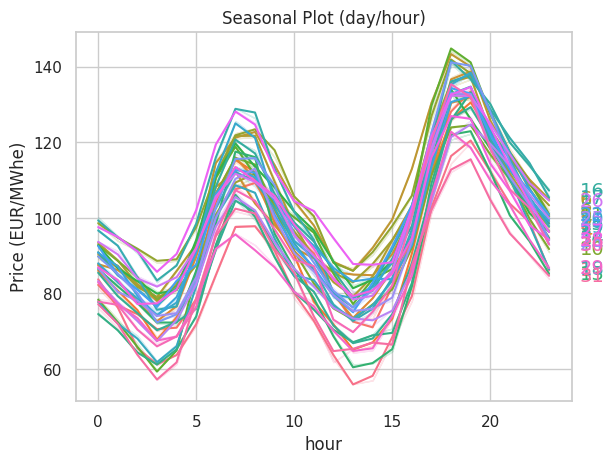

In [272]:
df = pd.DataFrame(prices2023)
df.index = weather_train.index
df["day"] = df.index.day
df["hour"] = df.index.hour
seasonal_plot(df, "Price (EUR/MWhe)", "day", "hour", ax=None)

In [273]:
y = prices2023.copy()
y.index = weather_train.index
y_test.index = weather_test.index

In [274]:
fourier = CalendarFourier(freq = "YE", order = 12) # YE is stead of A
fourier_D = CalendarFourier(freq = "D", order = 6)
fourier_W = CalendarFourier(freq = "W", order = 6)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=2,
    seasonal = False,
    additional_terms = [fourier, fourier_D,fourier_W],
    drop=True,
)
X = dp.in_sample()

fore_period = 24*(3*30 + 15)
forecast_index = pd.date_range(
    start = y.index[-1] + pd.Timedelta(hours=1),
    periods = fore_period,
    freq = "h",
)

X_test_aux = dp.out_of_sample(steps = fore_period, forecast_index = forecast_index)

In [275]:
X = pd.concat([X, X_test_aux], axis = 0)

### Calandar Features

The Calandar Features are also very much important for the model, especially the hour in a day or the month.

We also created some Features by multiplying hour by day of the week for example, to create some interractions.

In [276]:
X['hour'] = X.index.hour
X['dayofweek'] = X.index.dayofweek
X['day'] = X.index.day
X['month'] = X.index.month
X['hourxdayofweek'] = X['hour'] * X['dayofweek']
X['hourxday'] = X['hour'] * X['day']

fr_holidays_23 = holidays.France(years=[2023])
fr_holidays_24 = holidays.France(years=[2024])

X["is_holiday"] = np.isin(X.index.date, list(fr_holidays_23.keys()) + list(fr_holidays_24.keys()) ).astype(int)

X['is_weekend'] = (X.index.dayofweek >= 5).astype(int)


In [277]:
is_weekend_X = X.index.dayofweek >= 5

# multiplier toutes les colonnes Fourier journalières par is_weekend pour créer interaction
fourier_day_cols = [c for c in X.columns if 'D_' in c]
for col in fourier_day_cols:
    X[f"{col}_wkend"] = X[col] * is_weekend_X.astype(int)

peak_hours_morning = [7,8,9]
peak_hours_evening = [18,19,20]

X['peak_morning'] = (X.index.hour.isin(peak_hours_morning)).astype(int)
X['peak_evening'] = (X.index.hour.isin(peak_hours_evening)).astype(int)

In [278]:
X = X.merge(GTT.Ouverture, how ='inner', left_index=True, right_index=True)
X = X.merge(weather_transf, how='inner', left_index=True, right_index=True)
X.head()

,const,trend,trend_squared,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)",...,wind_direction_100m_44,wind_direction_100m_52,wind_direction_100m_75,wind_direction_100m_84,wind_speed_100m_11,wind_speed_100m_24,wind_speed_100m_44,wind_speed_100m_52,wind_speed_100m_75,wind_speed_100m_84
2023-01-01 00:00:00,1.0,1.0,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,189.0,211.0,178.0,192.0,48.8,53.2,35.7,52.7,34.9,40.8
2023-01-01 01:00:00,1.0,2.0,4.0,0.000717,1.000000,0.001435,0.999999,0.002152,0.999998,0.002869,...,188.0,211.0,183.0,188.0,49.4,49.8,36.0,54.9,34.2,41.8
2023-01-01 02:00:00,1.0,3.0,9.0,0.001435,0.999999,0.002869,0.999996,0.004304,0.999991,0.005738,...,193.0,210.0,196.0,187.0,46.0,52.9,40.3,55.5,36.0,44.6
2023-01-01 03:00:00,1.0,4.0,16.0,0.002152,0.999998,0.004304,0.999991,0.006455,0.999979,0.008607,...,194.0,217.0,200.0,191.0,42.4,46.0,38.5,55.2,34.2,43.6
2023-01-01 04:00:00,1.0,5.0,25.0,0.002869,0.999996,0.005738,0.999984,0.008607,0.999963,0.011476,...,199.0,218.0,201.0,188.0,38.3,41.3,40.8,49.5,30.8,45.1


### Lag-based Features

In [315]:
X.columns = [c.replace('(', '_').replace(')', '_').replace(',', '_').replace('=', '_').replace('-', '_') for c in X.columns]

In [316]:
X_full = X.copy()
mask23 = (prices.index.year == 2023)
mask24 = (prices.index.year == 2024) & (prices.index <= "2024-04-15 00:00:00")
y_full = prices[mask23 | mask24]['Price (EUR/MWhe)']
y_full.index = X.index # to correct the duplicated dates !

By looking at the Partial Autocorrelation diagram, we notice a strong correlation with previous values, especially lag 1, but also with other values (basically the whole previous 24 hours).

Additonally, we will add other features like the 24h and 12h rolling mean and standard deviation in order to account for the variability of the data. We will also add some features indicating relative variations between prices (h-2 and h-1) and identify if the are sudden peaks based on the Z-score.

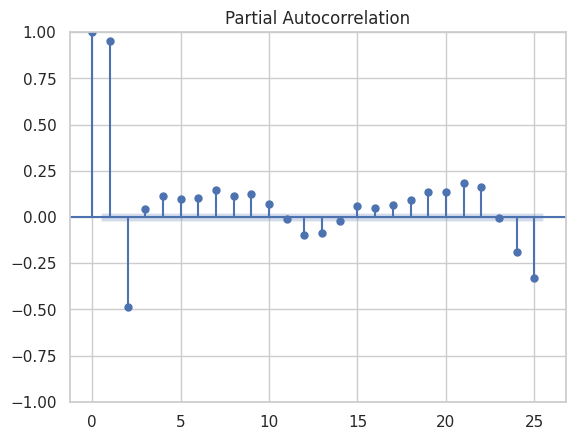

In [281]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y, lags=25);

In [317]:
X_full["24h_mean"] = y_full.shift(1).rolling(window=24, center = False).mean()
X_full["12h_mean"] = y_full.shift(1).rolling(window=12, center = False).mean()
X_full["24h_std"] = y_full.shift(1).rolling(window=24, center = False).std()
X_full["12h_std"] = y_full.shift(1).rolling(window=12, center = False).std()

for i in range(1, 25) :
  X_full[f"lag_{i}"] = y_full.shift(i)


In [318]:
X_full["price_change"] = y_full.shift(1).diff()

In [319]:
X_full["price_zscore"] = (y_full.shift(1) - X_full["24h_mean"]) / X_full["24h_std"]
X_full["z_spike"] = (X_full["price_zscore"].abs() > 3).astype(int)

In [320]:
X_full["spike_intensity"] = X_full["price_zscore"].abs()

In [321]:
window = 168

q168_10 = y_full.shift(1).rolling(window).quantile(0.10)
q168_50 = y_full.shift(1).rolling(window).quantile(0.50)
q168_90 = y_full.shift(1).rolling(window).quantile(0.90)

iqr168 = q168_90 - q168_10

In [322]:
X_full["q168_10"] = q168_10
X_full["q168_50"] = q168_50
X_full["iqr168"] = iqr168

In [323]:
X_full.dropna(inplace = True, axis = 0)

# A single Model approach

**Initial XGBoost Model**

We will start by an XGBoost model using randomly chosen parameters, then we will use bayesian optimization for hypertuning the model.

In [324]:
{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 15, 'n_estimators': 700, 'min_child_samples': 20, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

{'subsample': 1.0,
 'reg_lambda': 0.1,
 'reg_alpha': 0.1,
 'num_leaves': 15,
 'n_estimators': 700,
 'min_child_samples': 20,
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bytree': 1.0}

We will divide in two steps to create training, test (or validation), and the forecast set.

In [334]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full[window:], test_size=fore_period/len(X_full), shuffle = False)

In [335]:
X_test, X_fore, y_test, y_fore = train_test_split(X_test, y_test, test_size=15*24/len(X_test), shuffle = False)

In [336]:
model = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    subsample = 1.0,
    reg_lambda = 0.1,
    reg_alpha = 0.1,
    n_estimators = 700,
    max_depth = 3,
    learning_rate = 0.01,
    colsample_bytree = 1.0
)
model.fit(X_train,y_train)
y_pred = pd.Series(model.predict(X_train))

In [337]:
fig = go.Figure()

# Add trace for prices
fig.add_trace(go.Scatter(x=X_train.index, y = y_train, mode='lines', name='Price (EUR/MWhe)'))
fig.add_trace(go.Scatter(x=X_train.index, y = y_pred, mode='lines', name='Prediction'))

# Update layout
fig.update_layout(
    title='Electricity Prices in 2023',
    xaxis_title='Datetime (Local)',
    yaxis_title='Price (EUR/MWhe)',
    template='plotly_white'
)

# Show plot
fig.show()

In [338]:
from sklearn.metrics import r2_score

r2 = r2_score(y_train, y_pred)
print("R² = ", r2)

R² =  0.9628603733796953


In [339]:
y_hat = pd.Series(model.predict(X_test))
y_hat.index = X_test.index

In [340]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test.index, y = y_test, mode='lines', name='Price (EUR/MWhe)'))
fig.add_trace(go.Scatter(x=X_test.index, y = y_hat , mode='lines', name='Prediction'))

# Update layout
fig.update_layout(
    title='Electricity Prices from 1st to 15th of january 2024',
    xaxis_title='Datetime (Local)',
    yaxis_title='Price (EUR/MWhe)',
    template='plotly_white'
)

# Show plot
fig.show()

In [341]:
error = mean_absolute_error(y_test, y_hat)
error

5.550696717723307

In [342]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_hat)
print("R² = ", r2)

R² =  0.9121520671885628


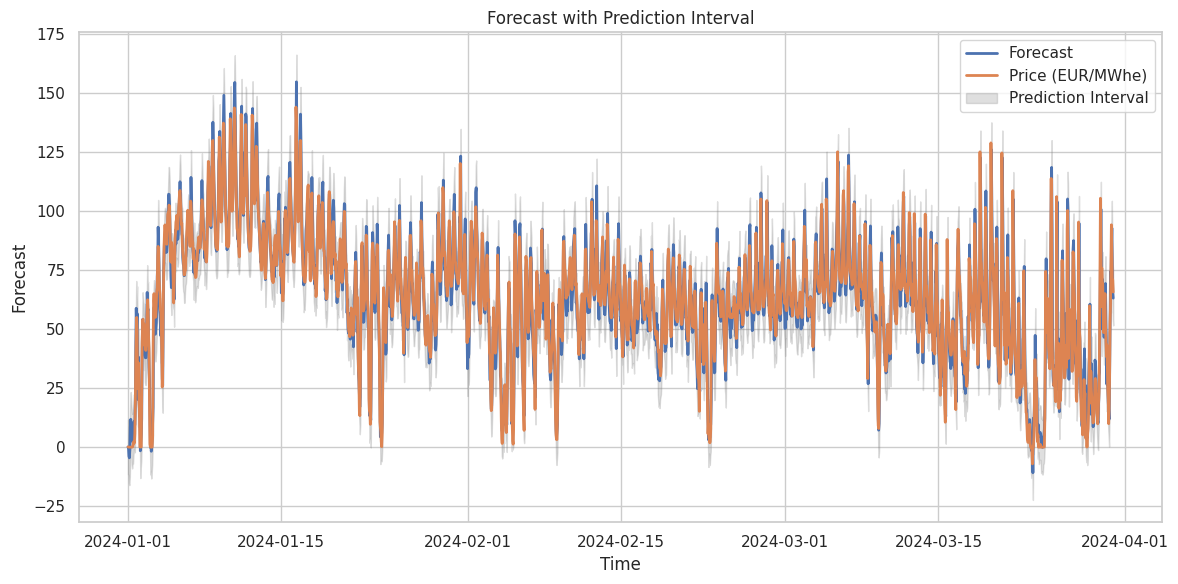

In [333]:
residuals = np.abs(y_test - y_hat)
q = np.quantile(residuals, 0.9)
lower = y_hat - q
upper = y_hat + q

import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Main forecast line
plt.plot(y_hat.index, y_hat, label="Forecast", linewidth=2)
plt.plot(X_test.index, y_test, label='Price (EUR/MWhe)', linewidth=2)

# Prediction interval (transparent gray)
plt.fill_between(
    y_hat.index, lower, upper,
    color="gray", alpha=0.25,
    label="Prediction Interval"
)

plt.xlabel("Time")
plt.ylabel("Forecast")
plt.title("Forecast with Prediction Interval")
plt.legend()
plt.tight_layout()
plt.show()


# Improvements

### Hyperparameters tunining using Bayesian Optmization

In [45]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.5 MB/s eta 0:00:00


In [98]:
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
        "random_state": 42,
        "objective": "reg:squarederror"
    }

    model = XGBRegressor(**params)

    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_train2, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train2, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train2, y_train2)
        preds = model.predict(X_val)
        scores.append(mean_squared_error(y_val, preds))

    return -np.mean(scores)  # maximize negative MSE

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best CV score:", study.best_value)

[I 2025-12-22 22:40:31,290] A new study created in memory with name: no-name-d848b263-8dd1-4c45-aae5-1e08158dfcd4
[I 2025-12-22 22:41:28,996] Trial 0 finished with value: -8.116322664622137 and parameters: {'n_estimators': 158, 'max_depth': 8, 'learning_rate': 0.07230327157333478, 'subsample': 0.758677687568115, 'colsample_bytree': 0.9042338981299457, 'reg_alpha': 0.7413435021844106, 'reg_lambda': 1.9673733553643866}. Best is trial 0 with value: -8.116322664622137.
[I 2025-12-22 22:43:36,593] Trial 1 finished with value: -38.231333427581816 and parameters: {'n_estimators': 461, 'max_depth': 8, 'learning_rate': 0.057993776291087824, 'subsample': 0.965543280870675, 'colsample_bytree': 0.646262629299553, 'reg_alpha': 0.47933617921999905, 'reg_lambda': 8.779106457557251}. Best is trial 0 with value: -8.116322664622137.
[I 2025-12-22 22:45:35,188] Trial 2 finished with value: -15.1743519957123 and parameters: {'n_estimators': 151, 'max_depth': 10, 'learning_rate': 0.07389145397356793, 'subs

Best parameters: {'n_estimators': 281, 'max_depth': 3, 'learning_rate': 0.05984896527253327, 'subsample': 0.6903254664045922, 'colsample_bytree': 0.971990411708081, 'reg_alpha': 7.4080537576088545, 'reg_lambda': 2.506167152809447}
Best CV score: -5.154131370187199


In [100]:
Best_parameters = study.best_params

### Random Search Hypertuning for LightLGB model

In [91]:
param_grid = {
    "num_leaves":        [7, 15, 31],   # shallow trees
    "max_depth":         [3, 4, 5],
    "learning_rate":     [0.005, 0.01, 0.05, 0.1],
    "n_estimators":      [300, 500, 700, 900],
    "subsample":         [0.6, 0.8, 1.0],
    "colsample_bytree":  [0.6, 0.8, 1.0],
    "reg_alpha":         [0.0, 0.1, 0.5],
    "reg_lambda":        [0.1, 1.0, 2.0],
    "min_child_samples": [10, 20, 40],
}


In [47]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# Sanitize column names for LightGBM compatibility
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

X_train_lgb.columns = [c.replace('(', '_').replace(')', '_').replace(',', '_').replace('=', '_').replace('-', '_') for c in X_train_lgb.columns]
X_test_lgb.columns = [c.replace('(', '_').replace(')', '_').replace(',', '_').replace('=', '_').replace('-', '_') for c in X_test_lgb.columns]


In [93]:

# shallow depth baseline model
lgbm = lgb.LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    verbosity=-1
)

tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    scoring="neg_mean_absolute_error",
    n_iter=40,
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_lgb, y_train)

best_params_lgb = search.best_params_

print("Best params:", search.best_params_)
print("Best MAE:", -search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 7, 'n_estimators': 700, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best MAE: 7.631381925680222


In [48]:
import lightgbm as lgb
best_model_lgb = lgb.LGBMRegressor(**best_params_lgb)
best_model_lgb.fit(X_train_lgb, y_train)
y_pred_lgb = pd.Series(best_model_lgb.predict(X_test_lgb))
y_pred_lgb.index = X_test.index

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26360
[LightGBM] [Info] Number of data points in the train set: 8736, number of used features: 139
[LightGBM] [Info] Start training from score 97.088086


In [ ]:
model_lgb = lgb.LGBMRegressor(
    max_depth=5,                  # forces smoothness
    learning_rate=0.1,
    n_estimators=300,
    subsample = 0.6,
    reg_lambda =0.1,
    reg_alpha = 0.0,
    num_leaves = 31,
    min_child_samples = 40,
    colsample_bytree = 0.6
)

model_lgb.fit(X_train_lgb, y_train)
y_pred_lgb = pd.Series(model_lgb.predict(X_test_lgb))
y_pred_lgb.index = X_test.index

In [49]:
r2 = r2_score(y_test, y_pred_lgb)
print("R² = ", r2)

R² =  0.9085714047348874


### Optimized Parameters

In [299]:
Best_parameters = {'n_estimators': 281, 'max_depth': 3, 'learning_rate': 0.05984896527253327,
                   'subsample': 0.6903254664045922, 'colsample_bytree': 0.971990411708081,
                   'reg_alpha': 7.4080537576088545, 'reg_lambda': 2.506167152809447}

In [300]:
best_params_lgb = {'subsample': 0.8,
                   'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 7,
                   'n_estimators': 700, 'min_child_samples': 20, 'max_depth': 5,
                   'learning_rate': 0.01, 'colsample_bytree': 1.0}


### Best Model

In [380]:
#Best_parameters = {'n_estimators': 369, 'max_depth': 9, 'learning_rate': 0.010052258964018256, 'subsample': 0.763277305549722, 'colsample_bytree': 0.6220572403874839, 'reg_alpha': 1.0615370711680965, 'reg_lambda': 0.615129378385445}

In [381]:
best_model_xgb = XGBRegressor(**Best_parameters)    # XGBRegressor(**study.best_params)
best_model_xgb.fit(X_train, y_train)
y_pred = pd.Series(best_model_xgb.predict(X_train))

In [382]:
fig = go.Figure()

# Add trace for prices
fig.add_trace(go.Scatter(x=X_train.index, y = y_train, mode='lines', name='Price (EUR/MWhe)'))
fig.add_trace(go.Scatter(x=X_train.index, y = y_pred, mode='lines', name='Prediction'))

# Update layout
fig.update_layout(
    title='Electricity Prices in 2023',
    xaxis_title='Datetime (Local)',
    yaxis_title='Price (EUR/MWhe)',
    template='plotly_white'
)

# Show plot
fig.show()

In [383]:
std = y_train.std()
mean = y_train.mean()
outliers = y_train[(np.abs(y_train) - mean > 3*std)]

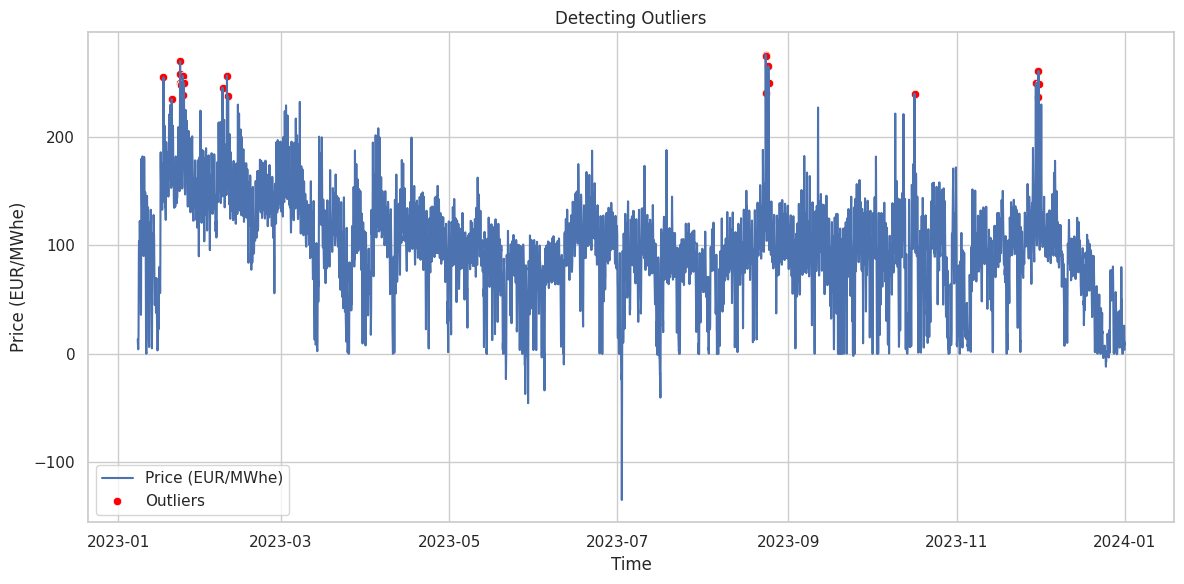

In [384]:
# Seaborn style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(y_train, label="Price (EUR/MWhe)")
sns.scatterplot(data = outliers, color="red", label="Outliers")
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWhe)")
plt.title("Detecting Outliers")
plt.legend()
plt.tight_layout()
plt.show()

<Axes: >

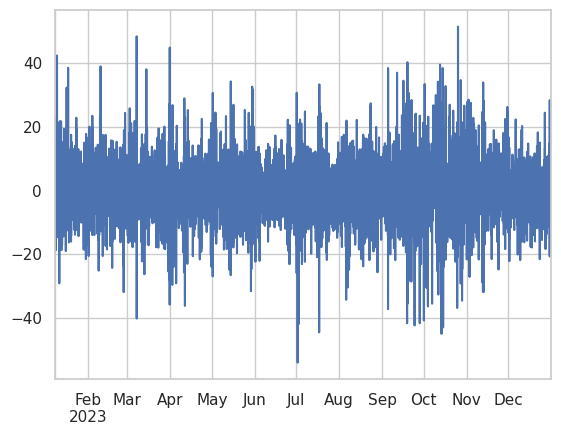

In [385]:
y_pred.index = y_train.index
residuals = y_train - y_pred
residuals.plot()

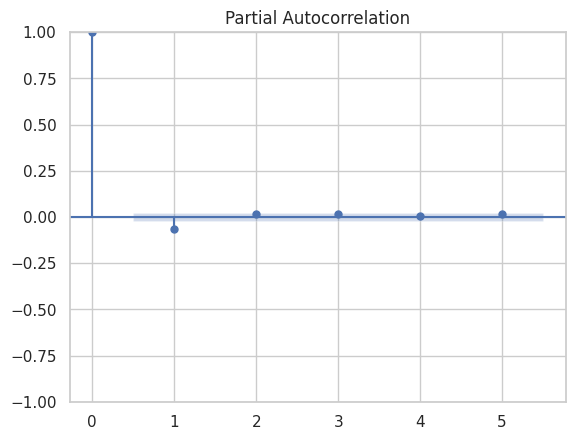

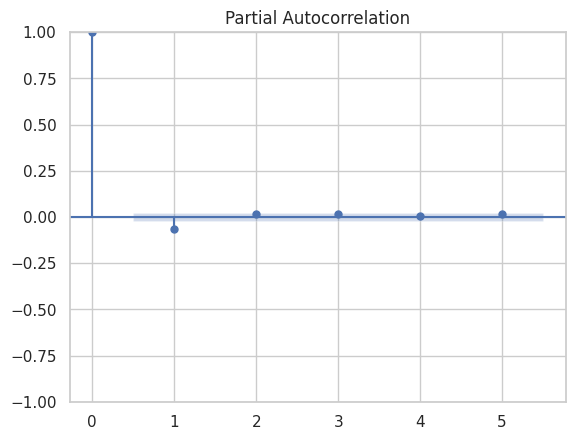

In [386]:
plot_pacf(residuals, lags= 5)

In [387]:
y_hat = pd.Series(best_model_xgb.predict(X_test))
y_hat.index = X_test.index

In [388]:
from sklearn.metrics import r2_score

r2 = r2_score(y_train, y_pred)
print("R² = ", r2)

R² =  0.9702092123279523


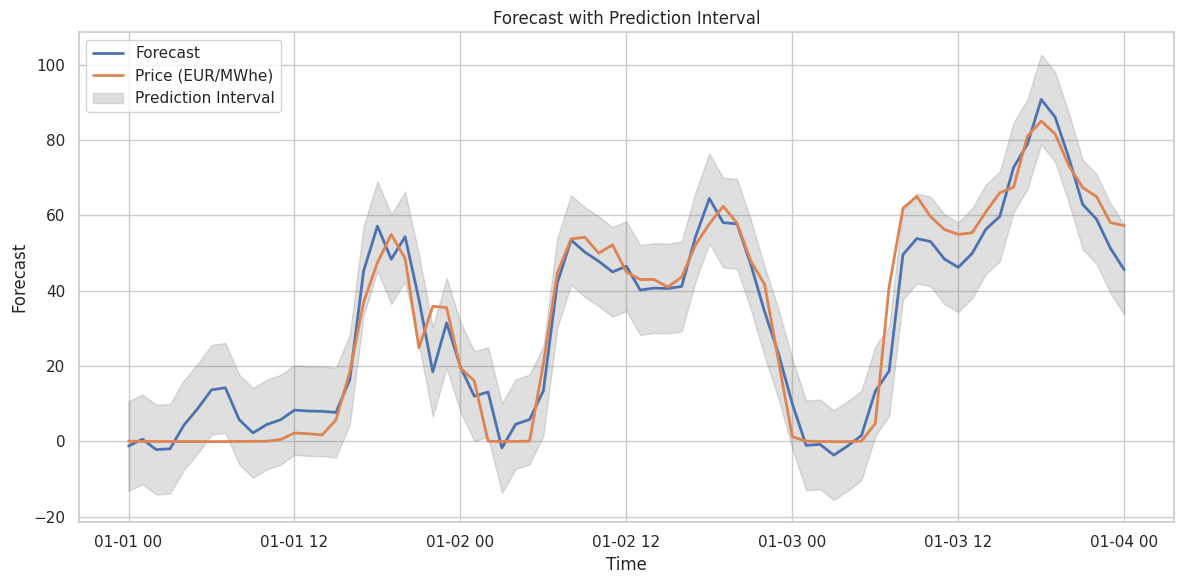

In [389]:
residuals = np.abs(y_test - y_hat)
q = np.quantile(residuals, 0.9)
lower = y_hat - q
upper = y_hat + q

import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Main forecast line
plt.plot(y_hat[:73].index, y_hat[:73], label="Forecast", linewidth=2)
#plt.plot(y_hat[:73].index, y_pred_lgb[:73], label="Forecast 2", linewidth=2)
plt.plot(X_test[:73].index, y_test[:73], label='Price (EUR/MWhe)', linewidth=2)

# Prediction interval (transparent gray)
plt.fill_between(
    y_hat[:73].index, lower[:73], upper[:73],
    color="gray", alpha=0.25,
    label="Prediction Interval"
)

plt.xlabel("Time")
plt.ylabel("Forecast")
plt.title("Forecast with Prediction Interval")
plt.legend()
plt.tight_layout()
plt.show()


In [390]:
error = mean_absolute_error(y_test, y_hat)
error

5.752144368947931

In [391]:
"""import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)"""


'import shap\n\nexplainer = shap.TreeExplainer(best_model)\nshap_values = explainer.shap_values(X_test)\nshap.summary_plot(shap_values, X_test)'

In [392]:
"""global_importance = np.abs(shap_values).mean(axis=0)
importance = pd.Series(global_importance, X_test.columns).sort_values(ascending=False)
display(importance.head(50))"""

'global_importance = np.abs(shap_values).mean(axis=0)\nimportance = pd.Series(global_importance, X_test.columns).sort_values(ascending=False)\ndisplay(importance.head(50))'

### Joblib saving

In [107]:
from joblib import dump
from datetime import datetime
import sklearn

artifact = {
    "model XGB": best_model_xgb,
    "model LGB": best_model_lgb,
    "features": X_train.columns.tolist(),
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
    "X_fore": X_fore,
    "y_fore": y_fore,
    "created_at": datetime.utcnow().isoformat(),
    "sklearn_version": sklearn.__version__,
    "params": best_model.get_params(),
}

dump(artifact, "model_bundle.joblib", compress=3)

/tmp/ipython-input-2115275825.py:15: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



['model_bundle.joblib']

In [2]:
from joblib import load

artifact = load("model_bundle.joblib")

#model2 = artifact["model"]
#features = artifact["features"]


FileNotFoundError: [Errno 2] No such file or directory: 'model_bundle.joblib'

# New Model : Meta-learner on XGBoost + Lightgbm + Ridge

### part 1

Stabilizes Variance (reduces heteroscedasticity)

Sales data usually has:

Very small values on some days,

Very large spikes on others.

This means the variance is not constant, and many models struggle with that.
The log transformation compresses large values and helps the model see patterns more clearly.

<Axes: xlabel='Price (EUR/MWhe)', ylabel='Density'>

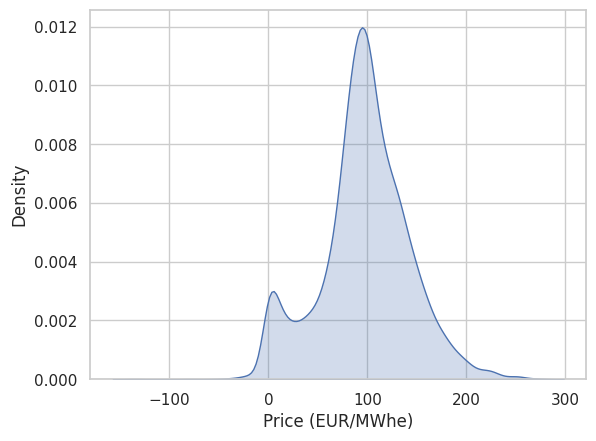

In [393]:
sns.kdeplot(data=y_train, fill=True)

In [394]:
from scipy.stats import skew
skew(y_fore, axis=0, bias=True)

np.float64(1.2947042627888299)

In [395]:
"""# ==============================
# Corrected Ridge Regression for Time Series
# ==============================

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

# ------------------------------------------------
# 1. Optional: Remove highly correlated features
# ------------------------------------------------

def drop_highly_correlated_features(X, threshold=0.98):
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return X.drop(columns=to_drop), to_drop


# ------------------------------------------------
# 2. Ridge pipeline (CRITICAL FIX)
# ------------------------------------------------

ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),   # mandatory
    ("ridge", Ridge(
        alpha=50.0,                # strong regularization
        fit_intercept=True,
        random_state=42
    ))
])


# ------------------------------------------------
# 3. Example training with time-series CV
# ------------------------------------------------

def train_ridge_ts(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    r2_scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        ridge_pipeline.fit(X_train, y_train)
        y_pred = ridge_pipeline.predict(X_val)

        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)

        print(f"Fold {fold} R²: {r2:.4f}")

    print(f"\nMean CV R²: {np.mean(r2_scores):.4f}")
    return ridge_pipeline


# ------------------------------------------------
# 4. Usage example
# ------------------------------------------------

# X = feature dataframe (lags, Fourier, calendar, weather, etc.)
# y = target series

# STEP 1: Remove redundant features
X_clean, dropped = drop_highly_correlated_features(X_train, threshold=0.98)
print(f"Dropped {len(dropped)} highly correlated features")

# STEP 2: Train corrected Ridge
ridge_model = train_ridge_ts(X_clean, y_train)

# STEP 3: Fit on full data (for stacking / production)
ridge_model.fit(X_clean, y_train)
"""

'# ==============================\n# Corrected Ridge Regression for Time Series\n# ==============================\n\nfrom sklearn.linear_model import Ridge\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.model_selection import TimeSeriesSplit\nfrom sklearn.metrics import r2_score\n\n# ------------------------------------------------\n# 1. Optional: Remove highly correlated features\n# ------------------------------------------------\n\ndef drop_highly_correlated_features(X, threshold=0.98):\n    corr = X.corr().abs()\n    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))\n    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]\n    return X.drop(columns=to_drop), to_drop\n\n\n# ------------------------------------------------\n# 2. Ridge pipeline (CRITICAL FIX)\n# ------------------------------------------------\n\nridge_pipeline = Pipeline([\n    ("scaler", StandardScaler()),   # mandatory\n   

In [396]:
"""# Predictions
y_pred_ridge = pd.Series(ridge_model.predict(X_test.drop(columns=dropped)))
y_pred_ridge.index = X_test.index
r2 = r2_score(y_test, y_pred_ridge)
print("R² = ", r2)"""

'# Predictions\ny_pred_ridge = pd.Series(ridge_model.predict(X_test.drop(columns=dropped)))\ny_pred_ridge.index = X_test.index\nr2 = r2_score(y_test, y_pred_ridge)\nprint("R² = ", r2)'

In [397]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=10.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = pd.Series(ridge_model.predict(X_test))
y_pred_ridge.index = X_test.index

r2 = r2_score(y_test, y_pred_ridge)
print("R² = ", r2)

R² =  0.8876211596619339


In [398]:
#!pip install catboost

In [399]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(
    loss_function="RMSE",
    depth=4,
    learning_rate=0.05,
    iterations=600,
    l2_leaf_reg=5,
    subsample=0.7,
    random_strength=0.5,
    bagging_temperature=0.3,
    verbose=False,
)

cat.fit(X_train, y_train)
y_pred_cat = pd.Series(cat.predict(X_test))
y_pred_cat.index = X_test.index

In [400]:
def check_stability(model, X, y, n_splits=5, model_name="model"):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []

    for i, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        r2 = r2_score(y_val, y_pred)
        scores.append(r2)

        print(f"{model_name} | Fold {i} R² = {r2:.4f}")

    scores = np.array(scores)
    print(f"\n{model_name} | Mean R² = {scores.mean():.4f}")
    print(f"{model_name} | Std  R² = {scores.std():.4f}")

    return scores

#check_stability(cat, X_train, y_train, n_splits=5, model_name="CatBoost")

In [401]:
import lightgbm as lgb

# Sanitize column names for LightGBM compatibility
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

model_lgb = lgb.LGBMRegressor(
    max_depth=5,                  # forces smoothness
    learning_rate=0.1,
    n_estimators=300,
    subsample = 0.6,
    reg_lambda =0.1,
    reg_alpha = 0.0,
    num_leaves = 31,
    min_child_samples = 40,
    colsample_bytree = 0.6
)

model_lgb.fit(X_train_lgb, y_train)
y_pred_lgb = pd.Series(model_lgb.predict(X_test_lgb))
y_pred_lgb.index = X_test.index

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26106
[LightGBM] [Info] Number of data points in the train set: 8592, number of used features: 137
[LightGBM] [Info] Start training from score 96.754406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

### Meta Model

In [402]:
meta_X = np.column_stack([y_hat,
                          y_pred_lgb,
                          y_pred_ridge,
                          y_pred_cat,
                          np.mean([y_hat, y_pred_lgb, y_pred_ridge, y_pred_cat], axis=0),
                          np.std([y_hat, y_pred_lgb, y_pred_ridge, y_pred_cat], axis=0),
                          y_test.index.hour,
                          X_test['iqr168'],
                          X_test['24h_std'],
                          X_test['12h_std'],
                          X_test['24h_mean'],
                          X_test['12h_mean']
                          ])
meta_y = y_test

In [403]:
meta_model = Ridge(alpha = 50.0)
meta_model.fit(meta_X, meta_y)

Ridge(alpha=50.0)

In [404]:
new_train, new_y = pd.concat([X_train, X_test], axis=0), pd.concat([y_train, y_test], axis=0)
best_model_xgb.fit(new_train, new_y)
y_pred_xgb2 = pd.Series(best_model_xgb.predict(new_train))

In [405]:
cat.fit(new_train, new_y)
y_pred_cat2 = pd.Series(cat.predict(new_train))

In [406]:
ridge_model.fit(new_train, new_y)
y_pred_ridge2 = pd.Series(ridge_model.predict(new_train))

In [407]:
new_train_lgb = new_train.copy()
new_y_lgb = new_y.copy()

best_model_lgb.fit(new_train_lgb, new_y_lgb)
y_pred_lgb2 = pd.Series(best_model_lgb.predict(new_train_lgb))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26124
[LightGBM] [Info] Number of data points in the train set: 10752, number of used features: 138
[LightGBM] [Info] Start training from score 90.048106


In [408]:
meta_model.coef_

array([-0.14049525,  0.19554231,  0.11655849,  0.54916706,  0.18019315,
        0.3263905 ,  0.05248408,  0.01475675, -0.07369836, -0.05310247,
        0.02498607,  0.04487197])

In [409]:
r2_score(meta_model.predict(meta_X), meta_y)

0.9204625650109617

In [411]:
f_pred_xgb = best_model_xgb.predict(X_fore)
f_pred_lgb = best_model_lgb.predict(X_fore)
f_pred_ridge = ridge_model.predict(X_fore)
f_pred_cat = cat.predict(X_fore)

final_pred = pd.Series(meta_model.predict(
    np.column_stack([
        f_pred_xgb,
        f_pred_lgb,
        f_pred_ridge,
        f_pred_cat,
        np.mean([f_pred_xgb, f_pred_lgb, f_pred_ridge, f_pred_cat], axis=0),
        np.std([f_pred_xgb, f_pred_lgb, f_pred_ridge, f_pred_cat], axis=0),
        y_fore.index.hour,
        X_fore['iqr168'],
        X_fore['24h_std'],
        X_fore['12h_std'],
        X_fore['24h_mean'],
        X_fore['24h_std'],
    ])
))

final_pred.index = X_fore.index


In [412]:
r2_score(y_fore, final_pred)

0.7382357004635673

In [413]:
predictions = [final_pred, f_pred_xgb, f_pred_lgb, f_pred_ridge, f_pred_cat ]
for e in predictions:
    print(mean_absolute_error(y_fore, e))


6.790997124722899
7.375572041051255
7.256245272411942
7.878673210927301
7.3816448355383635


In [414]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=X_fore.index, y = y_fore, mode='lines', name='Price (EUR/MWhe)'))
fig.add_trace(go.Scatter(x=X_fore.index, y = final_pred , mode='lines', name='Prediction'))

# Update layout
fig.update_layout(
    title='Electricity Prices from 1st to 15th of April 2024',
    xaxis_title='Datetime (Local)',
    yaxis_title='Price (EUR/MWhe)',
    template='plotly_white'
)

# Show plot
fig.show()

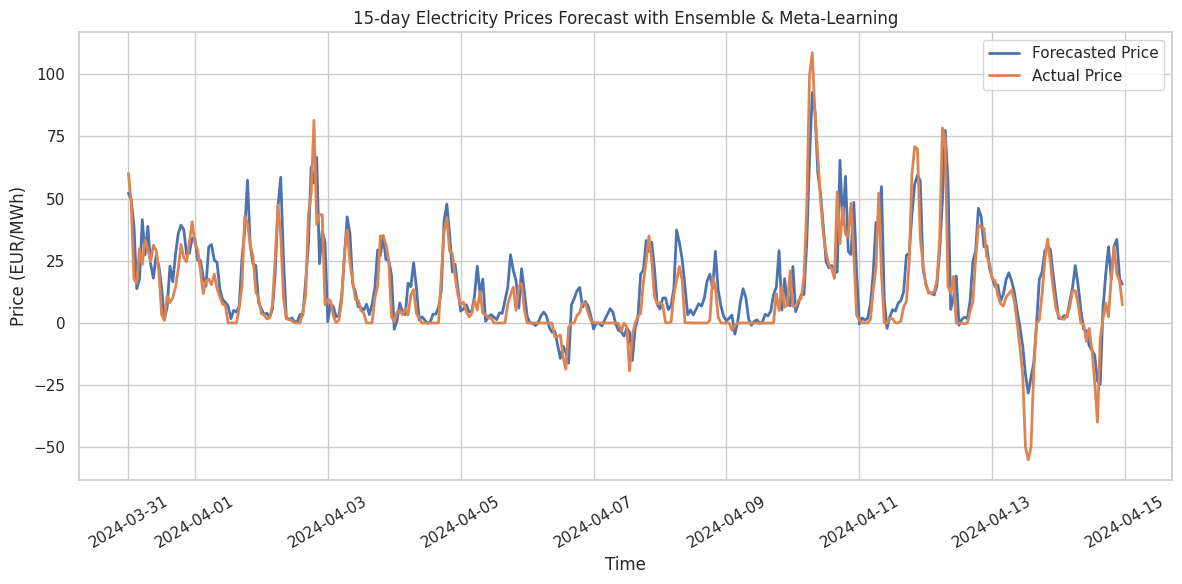

In [424]:
# Seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Main forecast line
plt.plot(y_fore.index, final_pred, label="Forecasted Price", linewidth=2)
plt.plot(X_fore.index, y_fore, label='Actual Price', linewidth=2)
plt.xticks(rotation=30)
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWh)")
plt.title("15-day Electricity Prices Forecast with Ensemble & Meta-Learning")
plt.legend()
plt.tight_layout()
plt.show()


eliminate prix bas haut...

# Task
Process the 'Volume' column of the `GTT` DataFrame, create a full hourly date range matching the `prices` DataFrame's index, reindex `GTT` to this new hourly range, and then forward-fill any missing values in `GTT` to transform the daily data into an hourly format.

## Process GTT data to hourly format and fill missing values

### Subtask:
Clean the 'Volume' column in the GTT DataFrame, create a full hourly date range matching the prices data, reindex GTT to this hourly range, and forward-fill missing values to convert daily data to hourly.


## Summary:

### Data Analysis Key Findings
*   The 'Volume' column in the `GTT` DataFrame was successfully cleaned by converting it to a numeric type, handling any non-numeric entries during the conversion.
*   An hourly date range was generated from 2013-01-01 00:00:00 to 2018-01-01 00:00:00, aligning with the temporal scope of the `prices` DataFrame.
*   The `GTT` DataFrame, originally containing daily data, was reindexed to this hourly frequency, and missing values were forward-filled, effectively transforming the daily volume data into an hourly representation.

### Insights or Next Steps
*   The transformation of `GTT` data to an hourly frequency with forward-filled values allows for consistent time-series analysis when integrating with other hourly datasets like `prices`.
*   This processed `GTT` data is now ready for use in feature engineering or direct inclusion in models that require hourly input.
